<hr>

## TABLE OF CONTENTS

1. [Packages](##1.-PACKAGES)

2. [Datasets](##2.-DATASETS)

3. [Analysis & Visualization](##3.-ANALYSIS-&-VISUALIZATION)

4. [Preprocessing & Pipeline](##4.-PREPROCESSING-&-PIPELINE)

5. [Model Prediction & Evaluation](##5.-MODEL-PREDICTION-&-EVALUATION)

6. [Model Comparison](##6.-MODEL-COMPARISON)

7. [Conclusion](##7.-CONCLUSION)

<hr>

## 1. PACKAGES

### Essential Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Machine Learning Libraries

In [2]:
# data pipeline:
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# preprocessing:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# model selection:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# models:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# metrics:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

<hr>

## 2. DATASETS

### Read CSV Files

In [3]:
df_2C = pd.read_csv('datasets/orthopedic_2C.csv')
df_3C = pd.read_csv('datasets/orthopedic_3C.csv')

In [4]:
print(df_2C.shape)
print(df_3C.shape)

(310, 7)
(310, 7)


In [5]:
# 2 dfs should have the same data structure and values:
if df_2C.iloc[:, :6].equals(df_3C.iloc[:, :6]):
    # Display the first 10 rows and 6 columns of df_2c
    display(df_2C.iloc[:10, :6])

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501
5,40.250200,13.921907,25.124950,26.328293,130.327871,2.230652
6,53.432928,15.864336,37.165934,37.568592,120.567523,5.988551
7,45.366754,10.755611,29.038349,34.611142,117.270067,-10.675871
8,43.790190,13.533753,42.690814,30.256437,125.002893,13.289018
9,36.686353,5.010884,41.948751,31.675469,84.241415,0.664437


In [6]:
print(df_2C['class'].unique())
print(df_3C['class'].unique())

['Abnormal' 'Normal']
['Hernia' 'Spondylolisthesis' 'Normal']


<hr>

## 3. ANALYSIS & VISUALIZATION

### Class Distribution

#### df_2C

In [7]:
distribution_2C = pd.DataFrame({
    'Class': df_2C['class'].value_counts().index,
    'Count': df_2C['class'].value_counts().values,
    'Percentage (%)': round(df_2C['class'].value_counts(normalize=True)*100,2)
}).reindex(['Normal', 'Abnormal'])

distribution_2C = distribution_2C.reset_index(drop=True)

display(distribution_2C.style.hide(axis="index"))

Class,Count,Percentage (%)
Normal,100,32.260000
Abnormal,210,67.740000


#### df_3C

In [8]:
distribution_3C = pd.DataFrame({
    'Class': df_3C['class'].value_counts().index,
    'Count': df_3C['class'].value_counts().values,
    'Percentage (%)': round(df_3C['class'].value_counts(normalize=True)*100,2)
}).reindex(['Normal', 'Hernia', 'Spondylolisthesis'])

distribution_3C = distribution_3C.reset_index(drop=True)

display(distribution_3C.style.hide(axis="index"))

Class,Count,Percentage (%)
Normal,100,32.260000
Hernia,60,19.350000
Spondylolisthesis,150,48.390000


### Missing Values

In [9]:
display(df_2C.isnull().sum())
display(df_3C.isnull().sum())

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
class                       0
dtype: int64

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
class                       0
dtype: int64

### Statistics

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


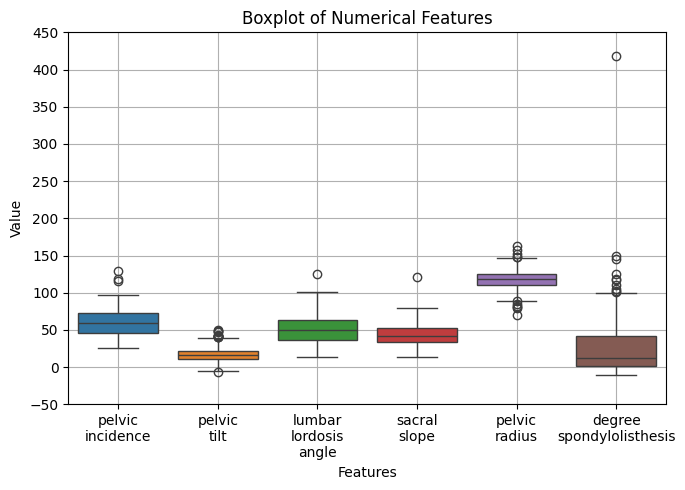

In [10]:
display(df_2C.describe())

plt.figure(figsize=(7, 5))
ax = sns.boxplot(data=df_2C)
plt.title("Boxplot of Numerical Features")

plt.xlabel("Features")
original_labels = df_2C.columns[:6]
wrapped_labels = [label.replace('_', '\n') for label in original_labels]
ax.set_xticks(range(len(wrapped_labels)))
ax.set_xticklabels(wrapped_labels)

plt.ylabel("Value")
plt.yticks(range(-50, 451, 50))

plt.grid(True)
plt.tight_layout()
plt.show()

<hr>

## 4. PREPROCESSING & PIPELINE

### Label Encoding

* OneHotEncoder for df_2C's target variable y (with 2 classes)

* LabelEncoder for df_3C's target variable y (with 3 classes)

In [11]:
# Initialize Encoder
oh_encoder = OneHotEncoder(sparse_output=False)
lb_encoder = LabelEncoder()

#### df_2C

In [12]:
# Make a copy to reserve original data
df_2C_encoded = df_2C.copy()

# Apply OneHot encoder to 'class' and transform to an array
encoded_array_2C = oh_encoder.fit_transform(df_2C_encoded[['class']])
# Create a dataframe from the encoded array
encoded_df_2C = pd.DataFrame(encoded_array_2C, columns=oh_encoder.get_feature_names_out(['class']))
# Concatenate the encoded dataframe with the original dataframe
df_2C_encoded = pd.concat([df_2C_encoded, encoded_df_2C], axis=1)
# Drop the original 'class', and 'class_Normal' column
df_2C_encoded.drop(['class','class_Normal'], axis=1, inplace=True)

# Value Counts:
display(df_2C_encoded['class_Abnormal'].value_counts().sort_index(ascending=False))

display(df_2C_encoded.head())

class_Abnormal
1.0    210
0.0    100
Name: count, dtype: int64

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class_Abnormal
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,1.0
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1.0
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,1.0
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,1.0
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,1.0


#### df_3C

In [13]:
# Make a copy to reserve original data
df_3C_encoded = df_3C.copy()

# Custom classes: 'Normal'=0, 'Hernia'=1, 'Spondylolisthesis'=2
custom_classes = ['Normal', 'Hernia', 'Spondylolisthesis']
# Force custom order
lb_encoder.classes_ = np.array(custom_classes)
# Transform using the custom order
df_3C_encoded['class'] = lb_encoder.transform(df_3C_encoded['class'])

# Value Counts:
display(df_3C_encoded['class'].value_counts().sort_index(ascending=False))

display(df_3C_encoded.head())

class
2    150
1     60
0    100
Name: count, dtype: int64

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,1


### Feature Scaling

In [14]:
X_unscaled = df_2C_encoded.iloc[:, :6]

In [15]:
# Initate scaler:
scaler = StandardScaler()

In [16]:
numerical_cols = X_unscaled.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, numerical_cols)
    ],
    remainder='passthrough'
)

### Pipeline

#### Four pipelines
- RandomForest Model
    - df_2C
    - df_3C
- DecisionTree Model
    - df_2C
    - df_3C
- Naive Bayes Model
    - df_2C
    - df_3C

In [17]:
# Classifying objects:
rf_classifier = RandomForestClassifier(random_state=42)
dt_classifier = DecisionTreeClassifier(random_state=42)
nb_classifier = GaussianNB()

##### RandomForest model pipeline for df_2C

In [18]:
rf_pipeline_2C = Pipeline([
    ('classifier', clone(rf_classifier))
])

##### RandomForest model pipeline for df_3C

In [19]:
rf_pipeline_3C = Pipeline([
    ('classifier', clone(rf_classifier))
])

##### DecisionTree model pipeline for df_2C

In [20]:
dt_pipeline_2C = Pipeline([
    ('classifier', clone(dt_classifier))
])

##### DecisionTree model pipeline for df_3C

In [21]:
dt_pipeline_3C = Pipeline([
    ('classifier', clone(dt_classifier))
])

##### Naive Bayes model pipeline for df_2C

In [22]:
nb_pipeline_2C = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', clone(nb_classifier))
])

##### Naive Bayes model pipeline for df_3C

In [23]:
nb_pipeline_3C = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', clone(nb_classifier))
])

### Splitting

In [24]:
y_2C = df_2C_encoded['class_Abnormal']
y_3C = df_3C_encoded['class']

X_train_2C, X_test_2C, y_train_2C, y_test_2C = train_test_split(X_unscaled, y_2C, test_size=0.2, random_state=28, stratify=y_2C)
print(X_train_2C.shape, y_train_2C.shape, X_test_2C.shape, y_test_2C.shape)

X_train_3C, X_test_3C, y_train_3C, y_test_3C = train_test_split(X_unscaled, y_3C, test_size=0.2, random_state=82, stratify=y_3C)
print(X_train_3C.shape, y_train_3C.shape, X_test_3C.shape, y_test_3C.shape)

(248, 6) (248,) (62, 6) (62,)
(248, 6) (248,) (62, 6) (62,)


<hr>

## 5. MODEL PREDICTION & EVALUATION

### RandomForest Model

#### df_2C

In [25]:
rf_pipeline_2C.fit(X_train_2C, y_train_2C)
y_pred_rf_2C = rf_pipeline_2C.predict(X_test_2C)
accuracy_score(y_test_2C, y_pred_rf_2C)

0.8064516129032258

#### df_3C

In [26]:
rf_pipeline_3C.fit(X_train_3C, y_train_3C)
y_pred_rf_3C = rf_pipeline_3C.predict(X_test_3C)
accuracy_score(y_test_3C, y_pred_rf_3C)

0.8225806451612904

### DecisionTree Model

#### df_2C

In [27]:
dt_pipeline_2C.fit(X_train_2C, y_train_2C)
y_pred_dt_2C = dt_pipeline_2C.predict(X_test_2C)
accuracy_score(y_test_2C, y_pred_dt_2C)

0.7419354838709677

#### df_3C

In [28]:
dt_pipeline_3C.fit(X_train_3C, y_train_3C)
y_pred_dt_3C = dt_pipeline_3C.predict(X_test_3C)
accuracy_score(y_test_3C, y_pred_dt_3C)

0.7258064516129032

### Gaussian Naive Bayes Model

#### df_2C

In [29]:
nb_pipeline_2C.fit(X_train_2C, y_train_2C)
y_pred_nb_2C = nb_pipeline_2C.predict(X_test_2C)
accuracy_score(y_test_2C, y_pred_nb_2C)

0.7258064516129032

#### df_3C

In [30]:
nb_pipeline_3C.fit(X_train_3C, y_train_3C)
y_pred_nb_3C = nb_pipeline_3C.predict(X_test_3C)
accuracy_score(y_test_3C, y_pred_nb_3C)

0.8870967741935484

<hr>

## 6. MODEL COMPARISON

In [31]:
accuracy_score, precision_score, recall_score, f1_score

(<function sklearn.metrics._classification.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)>,
 <function sklearn.metrics._classification.precision_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 <function sklearn.metrics._classification.recall_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>,
 <function sklearn.metrics._classification.f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')>)

In [32]:
print("\ndf_2C")
for model, y_pred, y_test in zip(
    ['Random Forest', 'Decision Tree', 'Naive Bayes'],
    [y_pred_rf_2C, y_pred_dt_2C, y_pred_nb_2C],
    [y_test_2C, y_test_2C, y_test_2C]
):
    print(f"{model} - Accuracy: {accuracy_score(y_test, y_pred):.4f}, "
          f"Precision: {precision_score(y_test, y_pred):.4f}, "
          f"Recall: {recall_score(y_test, y_pred):.4f}, "
          f"F1 Score: {f1_score(y_test, y_pred):.4f}")

print("\ndf_3C")
for model, y_pred, y_test in zip(
    ['Random Forest', 'Decision Tree', 'Naive Bayes'],
    [y_pred_rf_3C, y_pred_dt_3C, y_pred_nb_3C],
    [y_test_3C, y_test_3C, y_test_3C]
):
    print(f"{model} - Accuracy: {accuracy_score(y_test, y_pred):.4f}, "
          f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}, "
          f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}, "
          f"F1 Score: {f1_score(y_test, y_pred, average='weighted'):.4f}")


df_2C
Random Forest - Accuracy: 0.8065, Precision: 0.8409, Recall: 0.8810, F1 Score: 0.8605
Decision Tree - Accuracy: 0.7419, Precision: 0.8095, Recall: 0.8095, F1 Score: 0.8095
Naive Bayes - Accuracy: 0.7258, Precision: 0.8571, Recall: 0.7143, F1 Score: 0.7792

df_3C
Random Forest - Accuracy: 0.8226, Precision: 0.8213, Recall: 0.8226, F1 Score: 0.8216
Decision Tree - Accuracy: 0.7258, Precision: 0.7609, Recall: 0.7258, F1 Score: 0.7391
Naive Bayes - Accuracy: 0.8871, Precision: 0.8836, Recall: 0.8871, F1 Score: 0.8844


<hr>

## 7. CONCLUSION